In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import numpy as np
import torch

import warnings
warnings.filterwarnings('ignore')

In [8]:
import matplotlib
import matplotlib.pyplot as plt

def smooth(x, window=5):
    return np.convolve(x, np.ones(window) / window, mode='valid')

def rescale(x):
    xnoN = x[~np.isnan(x)]
    return (x - np.min(xnoN)) / (np.max(xnoN) - np.min(xnoN))

plt.rcParams['axes.linewidth'] = 1
plt.rcParams['axes.titlepad'] = 1
plt.rcParams['axes.labelpad'] = 1
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['xtick.major.width'] = 1
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['ytick.major.width'] = 1
plt.rcParams['font.size'] = 6
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['legend.framealpha'] = 0.
plt.rcParams['legend.handlelength'] = 1.25
plt.rcParams['image.origin'] = 'upper'
plt.rcParams['image.cmap'] = 'magma'
plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams['savefig.format'] = 'svg'
plt.rcParams['savefig.bbox'] = 'tight'
plt.rcParams['savefig.transparent'] = True
plt.rcParams['savefig.pad_inches'] = 0.
plt.rcParams['savefig.dpi'] = 200

In [9]:
from train_Burgers import *
from pprint import pprint

info = torch.load(f'tb_logs/burgers_dedalus_GFNN_b1e-06.ckpt', map_location='cpu')
model = GFNN(**info['hparams'])
pprint(info['hparams'])
u = np.load(f'data/burgers_dedalus.npy', mmap_mode='r')
print(u.shape)

model.load_state_dict(info['state_dict'])
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)
model.to(device)
model.eval();

print(f"device = {device}")
print(f"{info['epoch']}, MSE={info['loss']:.3g}, Kernel={model.get_kernel_loss():.3g}")

tmin, xmin = 0, 0
frame_rate = 60 / 4
pixel_size = 18 / (u.shape[1]) #mm
tmax = 50 / frame_rate
xmax = 100 * pixel_size

t = np.linspace(0, model.kernel.shape[0] / frame_rate, model.kernel.shape[0])
x = np.linspace(0, model.kernel.shape[1] * pixel_size, model.kernel.shape[1])

T, X = np.meshgrid(t, x, indexing='ij')
    
t0 = model.kernel.shape[0] // 2
dx = model.kernel.shape[1] // 2
x0 = x.shape[0] // 2

with torch.no_grad():
    y0 = torch.FloatTensor(u)[:50, -100:].to(device)
    x0 = y0[None, 0:1, :]
    
    b, t, l = x0.shape
    pad_size = [t, l + model.pad]
    
    phi1 = model.read_in(x0)
        
    xq = torch.fft.fft2(phi1, s=pad_size)
    xq = xq * model.get_kernel()[None]
    phi1 = torch.fft.ifft2(xq).real[..., :-model.pad, :-model.pad]
    y1 = model.read_out(phi1.reshape([-1, 1, l])).reshape([b, -1, l])
    
    k = 3
    y1 = F.avg_pool2d(y1[None], (1, k), stride=1, padding=(0, k//2))[0]
    phi1 = F.avg_pool2d(phi1[None], (1, k), stride=1, padding=(0, k//2))[0]
        
    y0 = y0.cpu().numpy().squeeze()
    y1 = y1.cpu().numpy().squeeze()
    
    phi1 = phi1.cpu().numpy().squeeze()

{'base_lr': 0.0001,
 'batch_size': 32,
 'beta': 1e-06,
 'device': 'cuda:0',
 'epochs': 1000,
 'kernel_lr': 0.01,
 'pad': 25,
 'size': [50, 100],
 'train_data': 'data/burgers_dedalus.npy'}
(112, 200)
cuda:0
device = cuda:0
902, MSE=0.000328, Kernel=4.3


GFNN:	MAE=0.018, r-MAE=0.044
Near shock:	MAE=0.014, r-MAE=0.020
Mean field:	MAE=0.139, r-MAE=0.333
Mean field near shock:	MAE=0.310, r-MAE=0.427


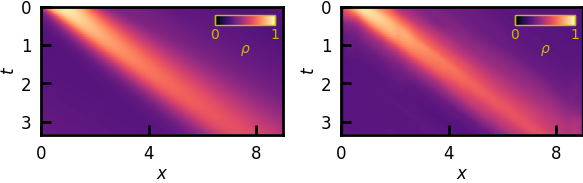

In [7]:
from sklearn.metrics import r2_score
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

kwargs = dict(extent=[xmin, xmax, tmax, tmin], vmin=0, vmax=1)

def plot_density_field(ax, rho, kwargs):
    #Note - video flows right to left, but we present things left to right
    im = ax.imshow(rho[:, ::-1], **kwargs)
    ax.set_aspect('auto')
    ax.set(xlabel='$x$', xticks=[0, 4, 8],
           ylabel='$t$', yticks=[0, 1, 2, 3])
    cbax = inset_axes(ax, width=0.3, height=0.05, loc='upper right')
    cbar = plt.colorbar(im, cax=cbax, ticks=[0,1], orientation='horizontal')
    color='y'
    fontsize=plt.rcParams['font.size'] - 1
    cbar.ax.set_xlabel('$\\rho$', fontsize=fontsize, color=color, labelpad=0.5)
    cbar.ax.set_xticklabels([0, 1], fontsize=fontsize, color=color)
    cbar.outline.set_edgecolor(color)
    cbar.outline.set_linewidth(0.5)
    cbar.ax.xaxis.set_tick_params(color='y', width=0.5, pad=1)
    plt.setp(plt.getp(cbax, 'xticklabels'), color=color)

def MAE(input, target):
    return np.mean(np.abs(input - target))
def rMAE(input, target):
    return np.mean(np.abs(input - target)) / np.mean(np.abs(target))
    
fig, ax = plt.subplots(1, 2, figsize=(3, 1), dpi=200, constrained_layout=True)

print(f'GFNN:\tMAE={MAE(y1, y0):.3f}, r-MAE={rMAE(y1, y0):.3f}')
y_mean = np.mean(y0)

#Fit a line through the maxes of y0 in order to define a shock mask
xx = X[0, :-25]
tt = T[:-25, 0]

maxes = np.argmax(y0, axis=1)
max_X = xx[maxes]
fit = np.polyfit(tt, max_X, deg=1)
max_X = tt * fit[0] + fit[1]

diff = xx[None, :] - max_X[:, None]

mask = np.ones(y0.shape, dtype=bool)
mask[np.abs(diff) > .5] = 0
print(f'Near shock:\tMAE={MAE(y1[mask], y0[mask]):.3f}, r-MAE={rMAE(y1[mask], y0[mask]):.3f}')
print(f'Mean field:\tMAE={MAE(y_mean, y0):.3f}, r-MAE={rMAE(y_mean, y0):.3f}')
print(f'Mean field near shock:\tMAE={MAE(y_mean, y0[mask]):.3f}, r-MAE={rMAE(y_mean, y0[mask]):.3f}')

plot_density_field(ax[0], y0, kwargs)
plot_density_field(ax[1], y1, kwargs)

#fig.savefig('Figures/DedalusBugers_predictions.svg', bbox_inches='tight')

[0, 5, 15, 25, 35]


(2.3333333333333335, 0.0)

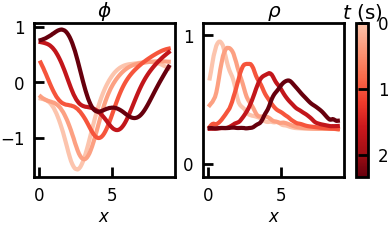

In [10]:
fig1, ax1 = plt.subplots(1, 2, figsize=(2, 1), dpi=200, 
                         sharex=True,
                         constrained_layout=False)

x = np.linspace(xmin, xmax, y1.shape[1])
ts = [0, 5, 15, 25, 35]
print(ts)

#Use a color offset to make the t = 0 visible
offset = 10
colors = [plt.cm.Reds((j+offset) / (ts[-1]+offset)) for j in ts]
for (t, color) in zip(ts, colors):
    ax1[0].plot(x[1:-1], phi1[t, ::-1][1:-1], c=color)
    ax1[1].plot(x[1:-1], y1[t, ::-1][1:-1], c=color)
        
'''
Formatting
'''
ax1[0].set_title('$\\phi$')
ax1[1].set_title('$\\rho$')
ax1[1].set(ylim=[-0.1, 1.1], yticks=[0, 1])

ax1[0].set(xlabel='$x$')
ax1[1].set(xlabel='$x$')


'''
Colorbars
'''
fig1.subplots_adjust(right=0.9)
norm = matplotlib.colors.Normalize(vmin=0, vmax=ts[-1] / frame_rate)
norm = matplotlib.colors.Normalize(vmin=-offset/frame_rate, vmax=ts[-1] / frame_rate)

y0 = ax1[1].get_position().y0
dy = ax1[1].get_position().y1 - y0
cax = fig1.add_axes([0.93, y0, 0.03, dy])
cbar = plt.colorbar(plt.cm.ScalarMappable(cmap='Reds', norm=norm),
                    cax=cax, ticks=[0, 1, 2])
cbar.ax.set_title('$t$ (s)')
ylim = cbar.ax.get_ylim()
cbar.ax.set_ylim([ylim[1], 0])

#fig1.savefig('Figures/DedalusBurgers_Internal.svg', bbox_inches='tight')

(75, 121)


Text(0.5, 1.0, '$t$ (s)')

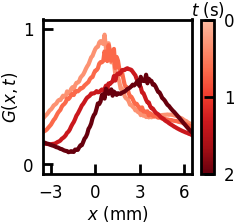

In [11]:
#Get kernel
with torch.no_grad():
    kernel = model.get_kernel()
    kernel = torch.fft.ifft2(kernel).real
    kernel = torch.fft.ifftshift(kernel, dim=-1)
    kernel = F.avg_pool2d(kernel[None], (1, 5), stride=1)[0]
    kernel = kernel.cpu().numpy()
    print(kernel.shape)
    kernels = rescale(kernel[:, ::-1]) #Remember x-axis is reversed in visualizing

k0 = kernel[0]
xi = np.arange(0, k0.shape[0]) - k0.shape[0] // 2
x_offset = xi[np.argmax(k0)] #Offset for traveling solutions
xi = (xi + x_offset).astype(float) * pixel_size

fig, ax = plt.subplots(1, 1, figsize=(1.2, 1), dpi=200, 
                         sharex=True, constrained_layout=False)

tmin, xmin = 0, 0
tmax = u.shape[0] / frame_rate
xmax = u.shape[1] * pixel_size

t = np.linspace(tmin, tmax, u.shape[0])
x = np.linspace(-xmax/2, xmax/2, u.shape[1])
T, X = np.meshgrid(t, x, indexing='ij')

offset = 10
dts = [5, 15, 25, 35]
dts = [5, 10, 15, 20, 25]
dts = [5, 10, 20, 30]

colors = [plt.cm.Reds((j+offset) / (dts[-1]+offset)) for j in dts]
for dt, color in zip(dts, colors):    
    ki = kernels[dt]
    ax.plot(xi, ki, c=color)
    
'''
Formatting
'''
ax.set(yticks=[0, 1], ylim=[-0.07, 1.07], ylabel='$G(x, t)$')
ax.set(xticks=[-3, 0, 3, 6], xlim=[-3.5, 6.5], xlabel='$x$ (mm)')


'''
Colorbars
'''

fig.subplots_adjust(right=0.9)
norm = matplotlib.colors.Normalize(vmin=0, vmax=dts[-1] / frame_rate)
norm = matplotlib.colors.Normalize(vmin=-offset/frame_rate, vmax=dts[-1] / frame_rate)

cbar = plt.colorbar(plt.cm.ScalarMappable(cmap='Reds', norm=norm), ax=ax, aspect=12, ticks=[2, 1, 0])
ylim = cbar.ax.get_ylim()
cbar.ax.set_ylim([ylim[1], 0])
cbar.ax.set_title('$t$ (s)', fontsize=plt.rcParams['axes.labelsize'])

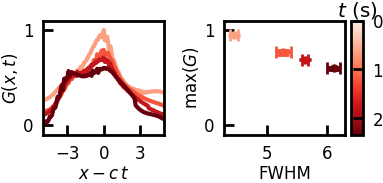

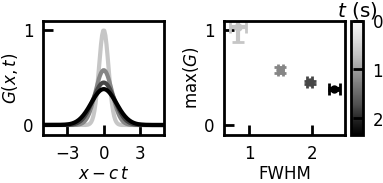

In [12]:
#Get kernel
with torch.no_grad():
    kernel = model.get_kernel()
    kernel = torch.fft.ifft2(kernel).real
    kernel = torch.fft.ifftshift(kernel, dim=-1)
    kernel = F.avg_pool2d(kernel[None], (1, 5), stride=1)[0]
    kernel = kernel.cpu().numpy()
    kernels = rescale(kernel[:, ::-1]) #Remember x-axis is reversed in visualizing

def fwhm(f, dx=pixel_size):
    #f is f[T, X]
    fmax = np.max(f)
    half_max = fmax / 2
    above = np.argwhere(f >= half_max)
    
    left = above.min()
    right = above.max()
    return (right - left) * dx

xmax = u.shape[1] * pixel_size
tmax = u.shape[0] / frame_rate
xx = np.linspace(-xmax/2, xmax/2, u.shape[1])
tt = np.linspace(-tmax/2, tmax/2, u.shape[0])
    
xmax = kernel.shape[1] * pixel_size
tmax = kernel.shape[0] / frame_rate
x = np.linspace(-xmax/2, xmax/2, kernel.shape[1])
t = np.linspace(-tmax/2, tmax/2, kernel.shape[0])

# The actual values used in the simulation
A, B, D = 2.792, -1.592, 0.233
def exact(x, t):
    return np.exp(-(x - A * t)**2 / (4 * D * t)) / np.sqrt(4 * np.pi * D * t)

t0 = kernel.shape[0] // 2
dts = [5, 15, 25, 35]
#dts = [5, 10, 20, 30]
escale = exact(x, dts[0] / frame_rate).max()

offset = 10
t_colors = [plt.cm.Reds((j+offset) / (dts[-1]+offset)) for j in dts]
e_colors = [plt.cm.Greys((j+offset) / (dts[-1]+offset)) for j in dts]

fig1, ax1 = plt.subplots(1, 2, figsize=(2, 1), dpi=200, constrained_layout=True)
fig2, ax2 = plt.subplots(1, 2, figsize=(2, 1), dpi=200, constrained_layout=True)

for i in range(len(dts)):
    ti = dts[i] / frame_rate
    ei = exact(xx + A * ti, ti) / escale
    ki = rescale(kernels[dts])[i]
    offset = x[np.argmax(ki)]
    xi = x - offset

    #Pad periodic (FFT) and interpolate to get full domain
    ki = np.concatenate([ki, ki])
    xii = np.concatenate([xi, xi+np.ptp(x) + (x[1]-x[0])])
    ax1[0].plot(xii, ki, c=t_colors[i])
    ax2[0].plot(xx, ei, c=e_colors[i])

    ki = kernels[dts[i]-2:dts[i]+3]
    t1 = np.linspace(-2, 2, 5) / frame_rate + ti
    ei = exact(xx[None, :], t1[:, None]) / escale
        
    fk = np.apply_along_axis(fwhm, 1, ki)
    fe = np.apply_along_axis(fwhm, 1, ei)
    
    mk = np.max(ki, axis=1)
    me = np.max(ei, axis=1)
    
    ax1[1].errorbar(fk.mean(), mk.mean(), 
                      yerr=mk.std(), xerr=fk.std(), 
                      linestyle='', color=t_colors[i], 
                      marker='o', markersize=2, capsize=2)
    ax2[1].errorbar(fe.mean(), me.mean(), 
                      yerr=me.std(), xerr=fe.std(), 
                      linestyle='', color=e_colors[i],
                      marker='o', markersize=2, capsize=2)

'''
Formatting
'''
for ax in (ax1, ax2):
    ax[0].set_ylabel('$G(x, t)$')
    ax[0].set(xlabel='$x - c\, t$')
    ax[0].set(xticks=[-3, 0, 3], xlim=[-5, 5])
    ax[0].set(yticks=[0, 1], ylim=[-0.1, 1.1])
    
    ax[1].set_xlabel('FWHM')
    ax[1].set_ylabel('$\max(G)$')
    ax[1].set(yticks=[0, 1], ylim=[-0.1, 1.1])

    ax[0].set_aspect('auto')
    ax[1].set_aspect('auto')

ax2[1].set_xticks([1, 2])

norm = matplotlib.colors.Normalize(vmin=0, vmax=dts[-1] / frame_rate)
norm = matplotlib.colors.Normalize(vmin=-offset/frame_rate, vmax=dts[-1] / frame_rate)
def add_colorbar(fig, ax, cmap='Reds'):
    cbar = fig.colorbar(plt.cm.ScalarMappable(cmap=cmap, norm=norm), ax=ax[1], ticks=[0,1,2], aspect=10)
    cbar.ax.set_title('$t$ (s)')
    ylim = cbar.ax.get_ylim()
    cbar.ax.set_ylim([ylim[1], 0])

add_colorbar(fig1, ax1, 'Reds')
add_colorbar(fig2, ax2, 'Greys')
fig1.savefig('Figures/DedalusBurgers_GF.svg', bbox_inches='tight')